In [1]:
# 📚 Import Libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 📥 Load the dataset
df = pd.read_csv('/content/Cleaned_LoanData.csv')

In [3]:
# 📊 Check data structure
print(df.head())
print(df.info())

   CreditScore FirstPaymentDate  FirstTimeHomebuyer MaturityDate  MIP  Units  \
0          584       1999-04-01                 0.0   2029-03-01    0      1   
1          584       1999-05-01                 0.0   2029-04-01    0      1   
2          584       1999-05-01                 0.0   2029-04-01    0      1   
3          584       1999-03-01                 0.0   2029-02-01    0      1   
4          584       1999-03-01                 0.0   2029-02-01    0      1   

   OCLTV  DTI  OrigUPB  LTV  ...  Channel_C Channel_R  Channel_T  \
0     71   21   116000   71  ...          0         0          1   
1     79   28    96000   79  ...          0         1          0   
2     66   18   101000   66  ...          0         1          0   
3     65   25    66000   65  ...          0         1          0   
4     80   38   234000   80  ...          0         0          1   

  DelinquencyCategory_0 DelinquencyCategory_1  DelinquencyCategory_2  \
0                     0               

In [4]:
df['FirstPaymentDate'] = pd.to_datetime(df['FirstPaymentDate'])
df['MaturityDate']  = pd.to_datetime(df['MaturityDate'])

In [5]:
# Separate column types
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
datetime_cols = df.select_dtypes(include=['datetime64']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)
print("Datetime Columns:", datetime_cols)


Numerical Columns: ['CreditScore', 'FirstTimeHomebuyer', 'MIP', 'Units', 'OCLTV', 'DTI', 'OrigUPB', 'LTV', 'OrigInterestRate', 'OrigLoanTerm', 'EverDelinquent', 'MonthsDelinquent', 'MonthsInRepayment', 'ComputedLoanTerm', 'LoanPurpose_P', 'LoanPurpose_R', 'Occupancy_INV', 'Occupancy_PR', 'Occupancy_SH', 'PropertyType_Condo', 'PropertyType_Multi-Family', 'PropertyType_Other', 'PropertyType_Single-Family', 'Channel_B', 'Channel_C', 'Channel_R', 'Channel_T', 'DelinquencyCategory_0', 'DelinquencyCategory_1', 'DelinquencyCategory_2', 'RepaymentCategory_0', 'RepaymentCategory_1', 'RepaymentCategory_2', 'DelinquencyFlag']
Categorical Columns: ['PropertyState', 'NumBorrowers', 'ServicerName', 'CreditScoreCategory', 'DTICategory', 'LoanRiskCategory']
Datetime Columns: ['FirstPaymentDate', 'MaturityDate']


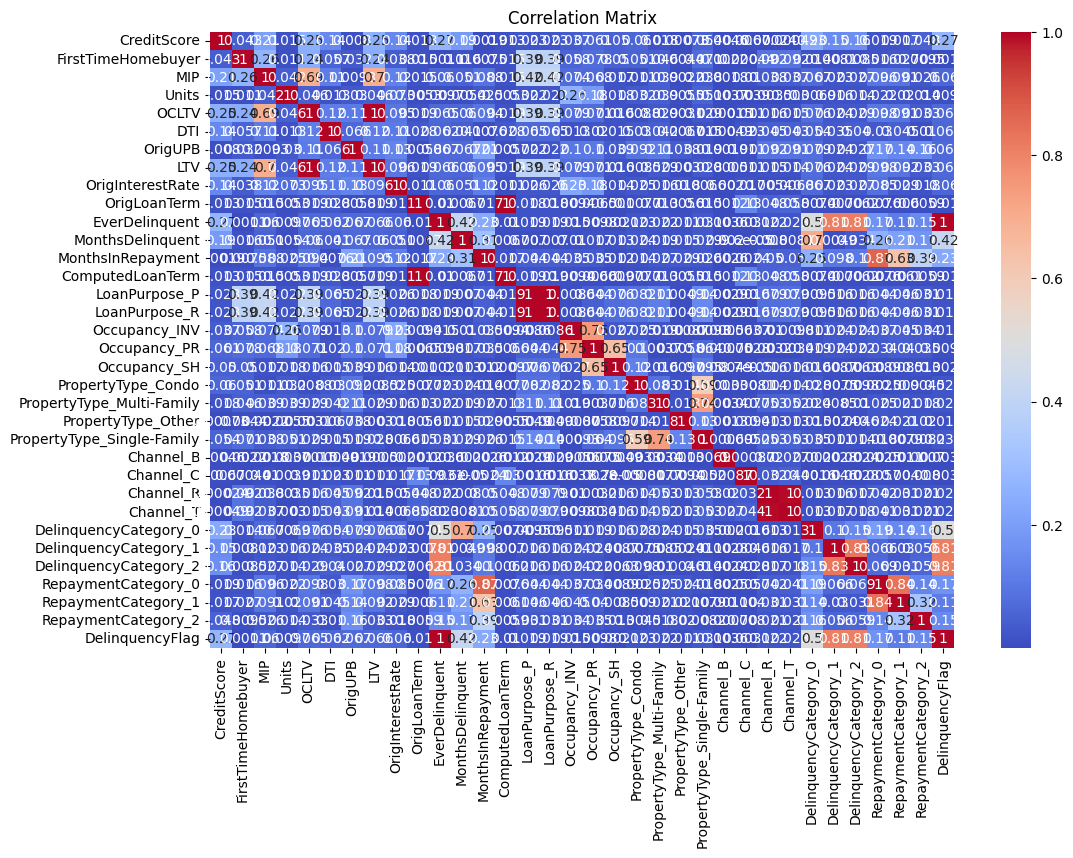

In [6]:
#Handle Multicollinearity
# Compute correlation matrix for numerical features
corr_matrix = df.select_dtypes(include=['float64', 'int64']).corr().abs()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [7]:
#Feature Importance Technique:
from sklearn.ensemble import RandomForestClassifier

X = df.drop(columns=['DelinquencyFlag'])
y = df['DelinquencyFlag']

# Encode categorical features
# Exclude datetime columns from get_dummies
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
X_encoded = pd.get_dummies(X[categorical_cols], drop_first=True)

# Add numerical features back to the encoded dataframe
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
X_encoded = pd.concat([X_encoded, X[numerical_cols]], axis=1)

# Fit a random forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_encoded, y)

# Get feature importances
rf_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

rf_importance.head(10)

,Feature,Importance
93,MonthsDelinquent,0.266977
92,EverDelinquent,0.261569
110,DelinquencyCategory_1,0.179141
111,DelinquencyCategory_2,0.173709
109,DelinquencyCategory_0,0.071356
82,CreditScore,0.008831
94,MonthsInRepayment,0.008471
73,CreditScoreCategory_Fair,0.007165
79,LoanRiskCategory_Low Risk,0.004674
112,RepaymentCategory_0,0.003854


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Use a pipeline with scaling + L1 regularized logistic regression
lasso = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
)
lasso.fit(X_encoded, y)

# Get coefficients
lasso_coef = lasso.named_steps['logisticregression'].coef_[0]
lasso_df = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Lasso Coef': lasso_coef
}).sort_values('Lasso Coef', key=abs, ascending=False)

lasso_df.head(10)


,Feature,Lasso Coef
93,MonthsDelinquent,6.712997
111,DelinquencyCategory_2,-5.101267
110,DelinquencyCategory_1,4.893267
92,EverDelinquent,1.780684
109,DelinquencyCategory_0,0.919240
82,CreditScore,-0.029996
94,MonthsInRepayment,0.024277
73,CreditScoreCategory_Fair,-0.021868
112,RepaymentCategory_0,0.008856
90,OrigInterestRate,0.003468


In [9]:
from sklearn.feature_selection import mutual_info_classif

# Separate features and target
X = df.drop(columns=['DelinquencyFlag'])
y = df['DelinquencyFlag']

# Encode categorical features
# Exclude datetime columns from get_dummies
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
X_encoded = pd.get_dummies(X[categorical_cols], drop_first=True)

# Add numerical features back to the encoded dataframe
# Exclude datetime columns from numerical features
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in df.select_dtypes(include=['datetime64']).columns]
X_encoded = pd.concat([X_encoded, X[numerical_cols]], axis=1)

# Compute mutual information
mi_scores = mutual_info_classif(X_encoded, y)

# Create DataFrame of scores
mi_df = pd.DataFrame({'Feature': X_encoded.columns, 'MI Score': mi_scores})
mi_df.sort_values('MI Score', ascending=False, inplace=True)
mi_df.head(10)

,Feature,MI Score
92,EverDelinquent,0.504403
93,MonthsDelinquent,0.497075
111,DelinquencyCategory_2,0.332964
110,DelinquencyCategory_1,0.286372
109,DelinquencyCategory_0,0.103993
99,Occupancy_PR,0.056684
95,ComputedLoanTerm,0.052437
91,OrigLoanTerm,0.052325
85,Units,0.049304
113,RepaymentCategory_1,0.047141


In [10]:
#Mathematical Transformations:
# Make a copy of the original DataFrame to avoid altering it directly
df_fe = df.copy()

# Example mathematical transformations

# 1. Debt-to-Income per Unit
df_fe['DTI_per_Unit'] = df_fe['DTI'] / df_fe['Units']

# 2. Loan-to-Value Ratio difference
df_fe['LTV_OCLTV_Diff'] = df_fe['LTV'] - df_fe['OCLTV']

# 3. MIP to OrigUPB ratio
df_fe['MIP_to_LoanAmt'] = df_fe['MIP'] / (df_fe['OrigUPB'] + 1)  # +1 to avoid divide by zero

# 4. Interest Rate weighted by Credit Score
df_fe['WeightedRate'] = df_fe['OrigInterestRate'] * df_fe['CreditScore']

# 5. OrigUPB to Loan Term (proxy for monthly principal)
df_fe['MonthlyPrincipal'] = df_fe['OrigUPB'] / (df_fe['OrigLoanTerm'] + 1)

# Display the new columns
df_fe[['DTI_per_Unit', 'LTV_OCLTV_Diff', 'MIP_to_LoanAmt', 'WeightedRate', 'MonthlyPrincipal']].head()


,DTI_per_Unit,LTV_OCLTV_Diff,MIP_to_LoanAmt,WeightedRate,MonthlyPrincipal
0,21.0,0,0.0,4015.0,321.329640
1,28.0,0,0.0,4015.0,265.927978
2,18.0,0,0.0,3942.0,279.778393
3,25.0,0,0.0,3869.0,182.825485
4,38.0,0,0.0,3942.0,648.199446


In [11]:
#Aggregations: Aggregate data to a different granularity level
# Convert FirstPaymentDate to datetime if it's not already
df["FirstPaymentDate"] = pd.to_datetime(df["FirstPaymentDate"], errors="coerce")

# Create a new column for year-month (monthly granularity)
df["PaymentYearMonth"] = df["FirstPaymentDate"].dt.to_period("M")

# Group by year-month and calculate aggregation metrics
aggregated_df = df.groupby("PaymentYearMonth").agg({
    "OrigUPB": "mean",             # Average Original Unpaid Principal Balance
    "CreditScore": "mean",         # Average Credit Score
    "DelinquencyFlag": "count"     # Count of loans issued that month
}).rename(columns={"DelinquencyFlag": "LoanCount"}).reset_index()

# Show the result
aggregated_df.head()


,PaymentYearMonth,OrigUPB,CreditScore,LoanCount
0,1999-01,126625.000000,716.000000,8
1,1999-02,119936.244541,710.538865,2290
2,1999-03,124571.725105,713.595770,89125
3,1999-04,124977.533040,711.854064,90800
4,1999-05,124321.863834,710.678947,103550


In [12]:
#Date and Time Features
# Ensure FirstPaymentDate is in datetime format
df["FirstPaymentDate"] = pd.to_datetime(df["FirstPaymentDate"], errors="coerce")

# Extract time-based features
df["PaymentYear"] = df["FirstPaymentDate"].dt.year
df["PaymentMonth"] = df["FirstPaymentDate"].dt.month
df["PaymentQuarter"] = df["FirstPaymentDate"].dt.quarter
df["PaymentDayOfWeek"] = df["FirstPaymentDate"].dt.dayofweek  # 0 = Monday, 6 = Sunday

# Preview the new features
df[["FirstPaymentDate", "PaymentYear", "PaymentMonth", "PaymentQuarter", "PaymentDayOfWeek"]].head()


,FirstPaymentDate,PaymentYear,PaymentMonth,PaymentQuarter,PaymentDayOfWeek
0,1999-04-01,1999,4,2,3
1,1999-05-01,1999,5,2,5
2,1999-05-01,1999,5,2,5
3,1999-03-01,1999,3,1,0
4,1999-03-01,1999,3,1,0


In [13]:
# Convert date columns
df["FirstPaymentDate"] = pd.to_datetime(df["FirstPaymentDate"], errors="coerce")
df["MaturityDate"] = pd.to_datetime(df["MaturityDate"], errors="coerce")

# Create LoanAgeMonths as a domain-specific feature
df["LoanAgeMonths"] = ((df["MaturityDate"] - df["FirstPaymentDate"]) / pd.Timedelta(days=30)).round()


In [14]:
#Normalization:
from sklearn.preprocessing import MinMaxScaler

# Selecting a subset of numerical features to scale using MinMaxScaler
minmax_features = ["CreditScore", "OrigUPB", "DTI", "LoanAgeMonths"]

# Apply Min-Max Scaling
minmax_scaler = MinMaxScaler()
df_minmax_scaled = df[minmax_features].copy()
df_minmax_scaled[minmax_features] = minmax_scaler.fit_transform(df_minmax_scaled)

df_minmax_scaled.head()


,CreditScore,OrigUPB,DTI,LoanAgeMonths
0,0.0,0.395122,0.355932,0.983607
1,0.0,0.297561,0.474576,0.983607
2,0.0,0.321951,0.305085,0.983607
3,0.0,0.151220,0.423729,0.983607
4,0.0,0.970732,0.644068,0.983607


In [15]:
# Z-score Standardization
df_zscore_scaled = df[minmax_features].copy()
df_zscore_scaled = (df_zscore_scaled - df_zscore_scaled.mean()) / df_zscore_scaled.std()

df_zscore_scaled.head()


,CreditScore,OrigUPB,DTI,LoanAgeMonths
0,-2.539615,-0.165952,-0.685302,0.07186
1,-2.539615,-0.545562,-0.153377,0.07186
2,-2.539615,-0.450660,-0.913270,0.07186
3,-2.539615,-1.114978,-0.381344,0.07186
4,-2.539615,2.073749,0.606516,0.07186


In [16]:
# Log Transformation
log_features = ["OrigUPB", "LoanAgeMonths"]
df_log_transformed = df[log_features].copy()
df_log_transformed = np.log1p(df_log_transformed)

df_log_transformed.head()


,OrigUPB,LoanAgeMonths
0,11.661354,5.899897
1,11.472114,5.899897
2,11.522886,5.899897
3,11.097425,5.899897
4,12.363081,5.899897


In [17]:
# Polynomial Features:
poly_features = df[["CreditScore", "OrigUPB", "DTI"]].copy()

# Create polynomial and interaction terms
df_poly = pd.DataFrame()
df_poly["CreditScore^2"] = poly_features["CreditScore"] ** 2
df_poly["OrigUPB^2"] = poly_features["OrigUPB"] ** 2
df_poly["DTI^2"] = poly_features["DTI"] ** 2
df_poly["CreditScore*OrigUPB"] = poly_features["CreditScore"] * poly_features["OrigUPB"]
df_poly["CreditScore*DTI"] = poly_features["CreditScore"] * poly_features["DTI"]
df_poly["OrigUPB*DTI"] = poly_features["OrigUPB"] * poly_features["DTI"]

df_poly.head()


,CreditScore^2,OrigUPB^2,DTI^2,CreditScore*OrigUPB,CreditScore*DTI,OrigUPB*DTI
0,341056,13456000000,441,67744000,12264,2436000
1,341056,9216000000,784,56064000,16352,2688000
2,341056,10201000000,324,58984000,10512,1818000
3,341056,4356000000,625,38544000,14600,1650000
4,341056,54756000000,1444,136656000,22192,8892000


In [18]:
#  Quantile Transformation:
quantile_features = ["CreditScore", "OrigUPB", "DTI"]
df_quantile = df[quantile_features].copy()

# Apply rank transformation and scale to [0,1]
df_quantile = df_quantile.rank(method='average') / len(df_quantile)

df_quantile.head()


#  Quantile Transformation:
quantile_features = ["CreditScore", "OrigUPB", "DTI"]
df_quantile = df[quantile_features].copy()

# Apply rank transformation and scale to [0,1]
df_quantile = df_quantile.rank(method='average') / len(df_quantile)

df_quantile.head()


,CreditScore,OrigUPB,DTI
0,0.005138,0.492958,0.220139
1,0.005138,0.343824,0.408510
2,0.005138,0.386945,0.162057
3,0.005138,0.127798,0.317386
4,0.005138,0.959981,0.726490


In [19]:
# Robust Scaling:
robust_features = ["CreditScore", "OrigUPB", "DTI"]
df_robust_scaled = df[robust_features].copy()

# Median and IQR-based scaling
Q1 = df_robust_scaled.quantile(0.25)
Q3 = df_robust_scaled.quantile(0.75)
IQR = Q3 - Q1

df_robust_scaled = (df_robust_scaled - df_robust_scaled.median()) / IQR

df_robust_scaled.head()


,CreditScore,OrigUPB,DTI
0,-1.727273,-0.012987,-0.588235
1,-1.727273,-0.272727,-0.176471
2,-1.727273,-0.207792,-0.764706
3,-1.727273,-0.662338,-0.352941
4,-1.727273,1.519481,0.411765


In [20]:
# Max-Abs Scaling
maxabs_features = ["CreditScore", "OrigUPB", "DTI"]
df_maxabs_scaled = df[maxabs_features].copy()

# Divide each value by the maximum absolute value of its column
df_maxabs_scaled = df_maxabs_scaled / df_maxabs_scaled.abs().max()

df_maxabs_scaled.head()

,CreditScore,OrigUPB,DTI
0,0.73,0.483333,0.355932
1,0.73,0.400000,0.474576
2,0.73,0.420833,0.305085
3,0.73,0.275000,0.423729
4,0.73,0.975000,0.644068


In [21]:
from sklearn.decomposition import PCA

# Select numerical features and drop rows with NaNs
pca_features = df[["CreditScore", "OrigUPB", "DTI", "LoanAgeMonths", "LTV", "OCLTV"]].dropna()

# Standardize before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pca_features)

# Apply PCA to retain 95% variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Convert to DataFrame
df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
df_pca.head()


,PC1,PC2,PC3,PC4,PC5
0,0.111665,0.554109,-0.628519,-1.024477,-2.343482
1,0.843240,0.681368,-0.870486,-1.286709,-1.795550
2,-0.396817,0.480005,-0.861546,-1.150005,-2.463924
3,-0.478533,0.807516,-1.245799,-1.642304,-1.985449
4,1.410811,1.573951,1.357163,-0.191821,-2.204004


In [22]:
from sklearn.feature_selection import SelectKBest, chi2

# Prepare data: ensure all values are non-negative for chi2
chi_features = df[["CreditScore", "OrigUPB", "DTI", "LTV", "OCLTV"]].fillna(0)
target = df["DelinquencyFlag"].fillna(0).astype(int)

# Apply Chi-Square test
chi_selector = SelectKBest(score_func=chi2, k='all')
chi_selector.fit(chi_features, target)

# Show scores
pd.Series(chi_selector.scores_, index=chi_features.columns).sort_values(ascending=False)


,0
OrigUPB,2.937125e+07
CreditScore,7.401291e+04
DTI,6.528454e+03
LTV,3.771433e+03
OCLTV,3.752213e+03


In [23]:
from sklearn.linear_model import LassoCV

# Fill missing values and scale
lasso_X = chi_features.copy()
lasso_y = target

# Fit LassoCV to select features
lasso = LassoCV(cv=5).fit(lasso_X, lasso_y)

# Display coefficients
pd.Series(lasso.coef_, index=lasso_X.columns).sort_values(ascending=False)


,0
DTI,0.000000e+00
OCLTV,0.000000e+00
LTV,0.000000e+00
OrigUPB,-5.209531e-07
CreditScore,-1.558346e-03


In [24]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Use logistic regression with RFE
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=3)
rfe.fit(lasso_X, lasso_y)

# Show selected features
pd.Series(rfe.support_, index=lasso_X.columns)


,0
CreditScore,True
OrigUPB,False
DTI,False
LTV,True
OCLTV,True


In [25]:
# Combine selected features (example set based on your transformations)
df_model = pd.concat([
    df[['CreditScore', 'OrigUPB', 'DTI', 'LTV', 'OCLTV', 'LoanAgeMonths']],  # base features
    df_fe[['DTI_per_Unit', 'LTV_OCLTV_Diff', 'MonthlyPrincipal']],           # engineered
    df_poly,                                                                # polynomial
    df_pca.add_prefix("PCA_")                                               # PCA components
], axis=1)

# Drop rows with missing values (or use imputation)
df_model = df_model.dropna()

# Define target
y = df.loc[df_model.index, 'DelinquencyFlag'].astype(int)
X = df_model


In [26]:
import numpy as np

# Replace inf/-inf with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with any NaNs
X_clean = X.dropna()

# Align target `y` accordingly
y_clean = y.loc[X_clean.index]


In [27]:
df.to_csv("model_loan.csv")

**Modeling with XGBOOST**

In [28]:
# 🔄 Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42, stratify=y_clean)

In [29]:
X_train.dtypes

,0
CreditScore,int64
OrigUPB,int64
DTI,int64
LTV,int64
OCLTV,int64
LoanAgeMonths,float64
DTI_per_Unit,float64
LTV_OCLTV_Diff,int64
MonthlyPrincipal,float64
CreditScore^2,int64


In [30]:
# 📝 Set up XGBoost Classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

In [31]:
# ✅ Parameter Grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# ✅ GridSearchCV
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid,
                           scoring='accuracy', cv=3, n_jobs=-1, verbose=1)

# ✅ Fit without early stopping (early stopping is for final model)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:51:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 5],
                         'n_estimators': [50, 100], 'subsample': [0.8, 1]},
             scoring='accuracy', verbose=1)

In [32]:
# 📌 Best parameters & score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

# ✅ Final model
best_model = grid_search.best_estimator_

Best parameters found:  {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}
Best cross-validation accuracy: 80.32%


In [33]:
# 📊 Predictions
y_pred = best_model.predict(X_test)

In [34]:
# 📈 Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.99      0.89     46585
           1       0.51      0.02      0.04     11467

    accuracy                           0.80     58052
   macro avg       0.66      0.51      0.47     58052
weighted avg       0.75      0.80      0.72     58052

Accuracy Score: 80.26%


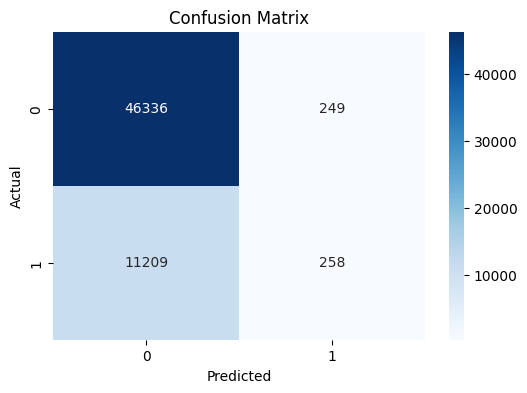

In [35]:
# 📉 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

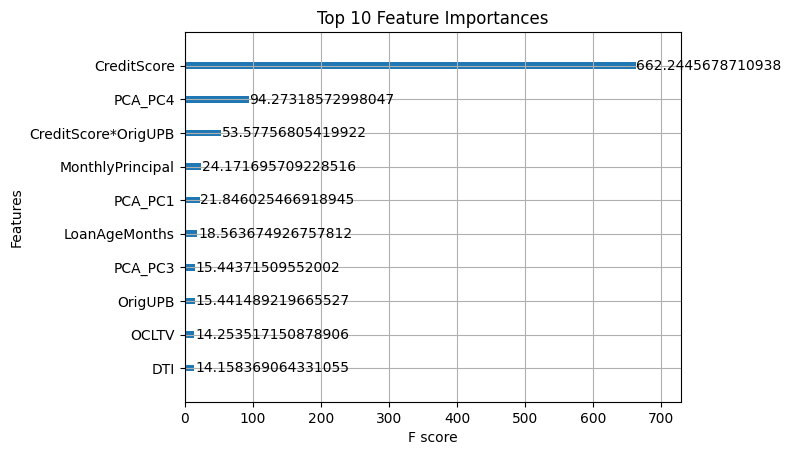

In [36]:
# 📊 Feature Importance
xgb.plot_importance(best_model, importance_type='gain', max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

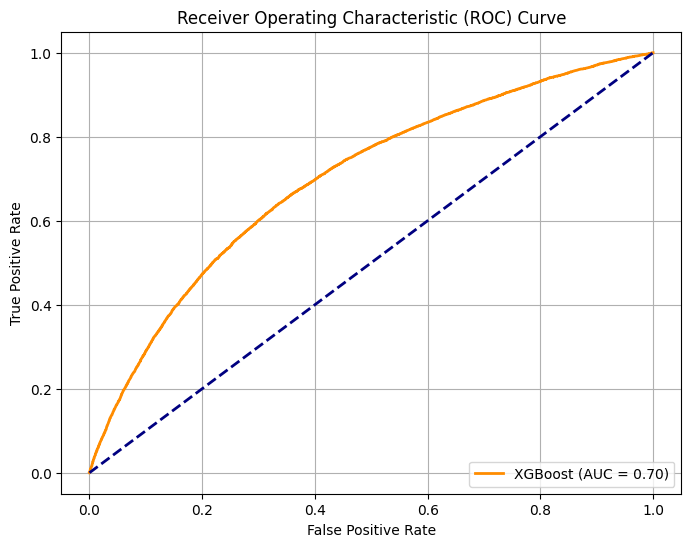

In [37]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities (for the positive class)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='XGBoost (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


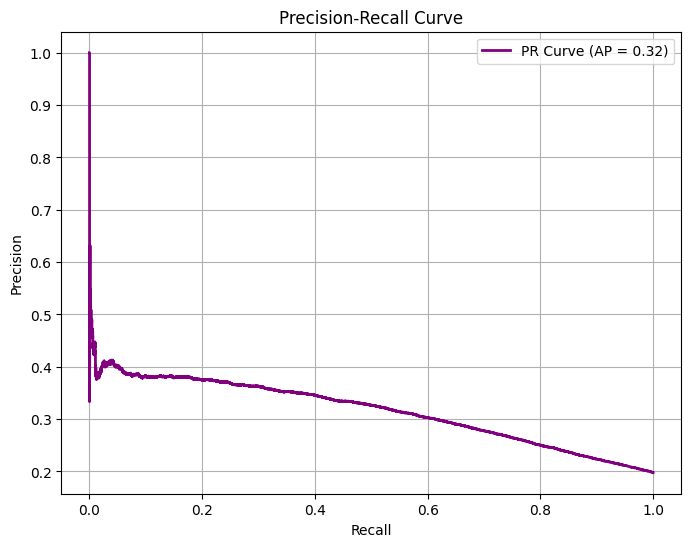

In [44]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get predicted probabilities for the positive class
y_proba = best_model.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Compute average precision score (optional but nice)
avg_precision = average_precision_score(y_test, y_proba)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid()
plt.show()


**Applying SMOTE**

After SMOTE: Counter({0: 186338, 1: 186338})
Fitting 3 folds for each of 32 candidates, totalling 96 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:09:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found:  {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation accuracy: 75.38%

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.80      0.82     46585
           1       0.34      0.42      0.38     11467

    accuracy                           0.73     58052
   macro avg       0.59      0.61      0.60     58052
weighted avg       0.75      0.73      0.74     58052

Accuracy Score: 72.52%


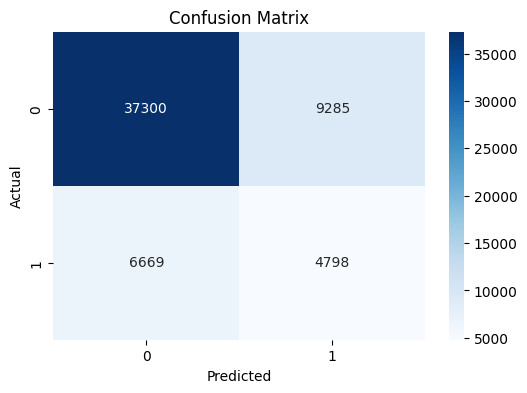

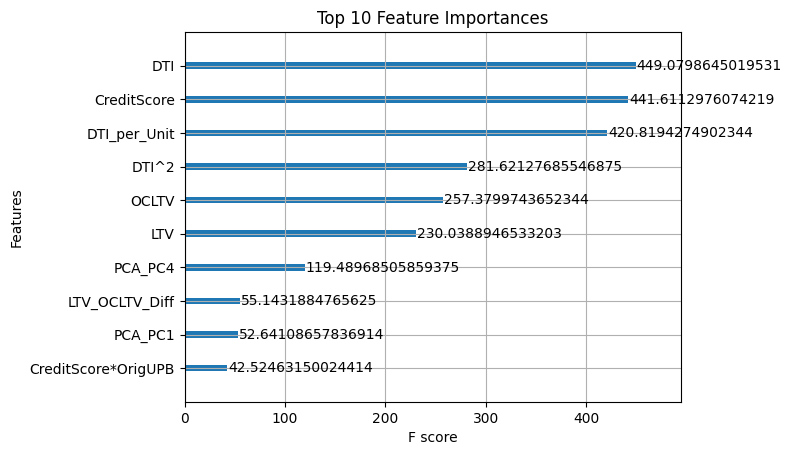

In [41]:
# 📊 Apply SMOTE
from imblearn.over_sampling import SMOTE  # for balancing
from collections import Counter

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("After SMOTE:", Counter(y_train_sm))

# ✅ Set up XGBoost Classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# ✅ Parameter Grid for GridSearch
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# ✅ GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid,
                           scoring='accuracy', cv=3, n_jobs=-1, verbose=1)


# 📈 Fit model on SMOTE-balanced training data
grid_search.fit(X_train_sm, y_train_sm)

# 📊 Best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

# ✅ Final model
best_model = grid_search.best_estimator_

# 📊 Predictions
y_pred1 = best_model.predict(X_test)

# 📈 Evaluation
print("\nClassification Report:\n", classification_report(y_test, y_pred1))
print("Accuracy Score: {:.2f}%".format(accuracy_score(y_test, y_pred1) * 100))

# 📉 Confusion Matrix
cm = confusion_matrix(y_test, y_pred1)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 📊 Feature Importance
xgb.plot_importance(best_model, importance_type='gain', max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()

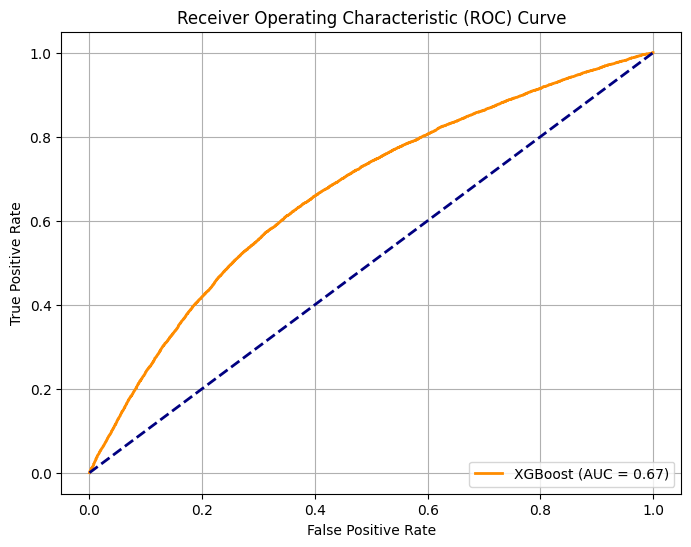

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get predicted probabilities (for the positive class)
y_proba1= best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_proba1)
roc_auc = roc_auc_score(y_test, y_proba1)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='XGBoost (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


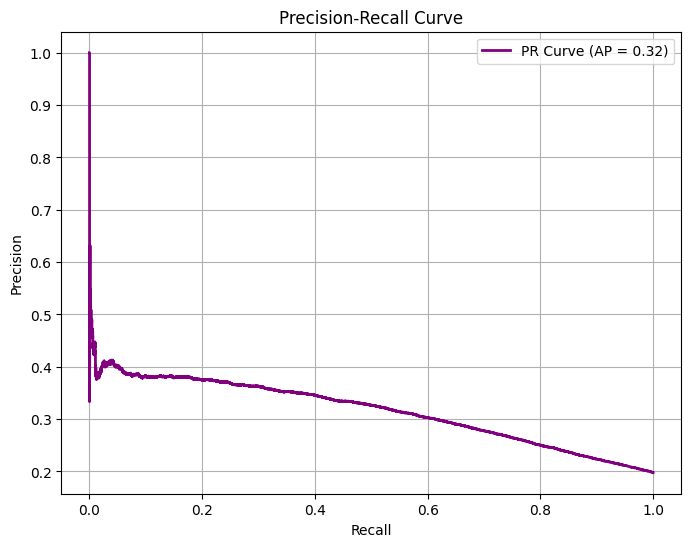

In [43]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get predicted probabilities for the positive class
y_proba = best_model.predict_proba(X_test)[:, 1]

# Compute precision-recall pairs for different probability thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba1)

# Compute average precision score (optional but nice)
avg_precision = average_precision_score(y_test, y_proba1)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid()
plt.show()
